# Advanced Time Series Analysis in Python: Seasonality and Trend Analysis (Decomposition), Autocorrelation 
## and other advanced techniques to find relationship between multiple time series.
![](https://cdn-images-1.medium.com/max/1500/1*Vkes2H7Soxgdngi969oAEQ.jpeg)
<figcaption style="text-align: center;">
    <strong>
        Photo by 
        <a href='https://www.pexels.com/@bentonphotocinema?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Jordan Benton</a>
        on 
        <a href='https://www.pexels.com/photo/shallow-focus-photography-of-hourglass-1095602/?utm_content=attributionCopyText&utm_medium=referral&utm_source=pexels'>Pexels</a>
    </strong>
</figcaption>

## Setup

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams

plt.style.use("ggplot")
rcParams["figure.figsize"] = [12, 9]
rcParams["xtick.labelsize"] = 15
rcParams["ytick.labelsize"] = 15
rcParams["font.size"] = 15

warnings.filterwarnings("ignore")

## Introduction

Following my very [well-received post](https://medium.com/r?url=https%3A%2F%2Ftowardsdatascience.com%2Fevery-pandas-function-you-can-should-use-to-manipulate-time-series-711cb0c5c749%3Fsource%3Dyour_stories_page-------------------------------------) and [Kaggle notebook](https://medium.com/r/?url=https%3A%2F%2Fwww.kaggle.com%2Fbextuychiev%2Fevery-pandas-function-to-manipulate-time-series%2Fcomments) on every single Pandas function to manipulate time series, it is time to take the trajectory of this TS project to visualization.

This post is about the core processes that make up an in-depth time series analysis. Specifically, we will talk about:

- Decomposition of time series - seasonality and trend analysis
- Analyzing and comparing multiple time series simultaneously
- Calculating autocorrelation and partial autocorrelation and what they represent

and if seasonality or trends among multiple series affect each other.

Most importantly, we will build some very cool visualizations, and this image should be a preview of what you will be learning.

![](https://cdn-images-1.medium.com/max/800/1*ToUsutofdinrqAann6druA.png)

I hope you are as excited about learning these things as I when writing this article. Let's begin.

## 1. Decomposition of Time Series 

Any time series distribution has 3 core components:

1. **Seasonality** - does the data have a clear cyclical/periodic pattern?
2. **Trend** - does the data represent a general upward or downward slope?
3. **Noise** - what are the outliers or missing values that are not consistent with the rest of the data?

Deconstructing a time series into these components is called **decomposition**, and we will explore each one in detail.

### 1.1 Seasonality analysis

Consider this TPS July Kaggle playground dataset:

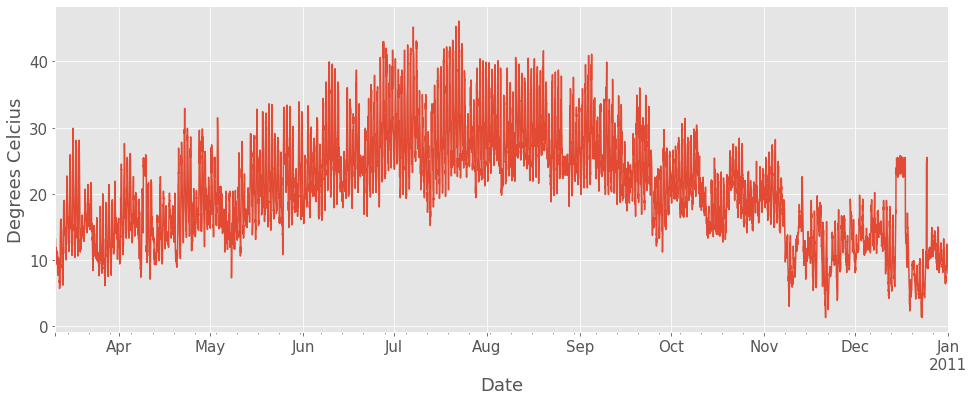

In [2]:
tps = pd.read_csv(
    "../input/tabular-playground-series-jul-2021/train.csv",
    parse_dates=["date_time"], index_col="date_time"
)

tps["deg_C"].plot(figsize=(16, 6), fontsize=15)
plt.xlabel("Date")
plt.ylabel("Degrees Celcius");

Obviously, summer months have higher temperatures, and we would expect this behavior to repeat every year. However, the human eye and its ability to detect patterns can only go so far.

For example, it might be harder to find seasonal patterns from plots such as these:

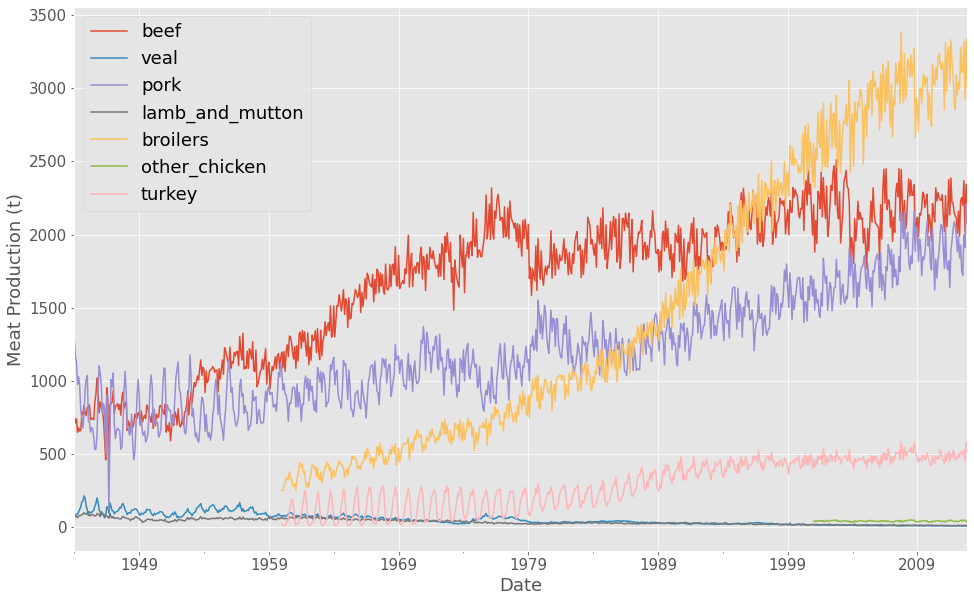

In [3]:
# Load meat production dataset in the USA
meat = pd.read_csv(
    "https://s3.amazonaws.com/assets.datacamp.com/production/course_5226/datasets/ch4_meat.csv", 
    parse_dates=["date"], index_col="date")

meat.plot(figsize=(16, 10))
plt.legend(fontsize="large")
plt.xlabel("Date")
plt.ylabel("Meat Production (t)");

To find hidden seasonal patterns from time series like above, we will use the `seasonal_decompose` function from `statsmodels`:

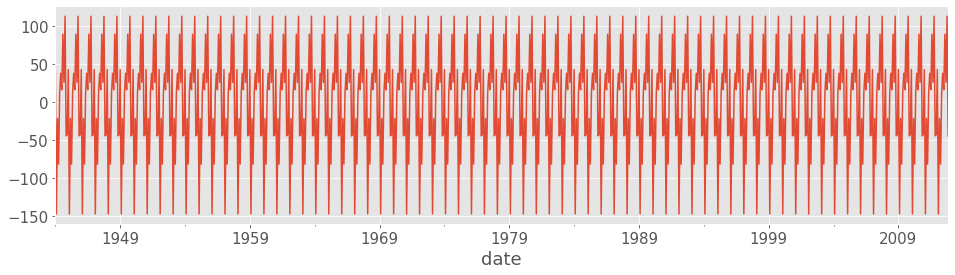

In [4]:
import statsmodels.api as sm
from matplotlib import rcParams

decomposition = sm.tsa.seasonal_decompose(meat["beef"])

rcParams["figure.figsize"] = 16, 4
decomposition.seasonal.plot();

Using `sm.tsa.seasonal_decompose` on 'beef' time-series returns a `DecomposeResult` object with attributes like seasonal, trend and resid (more on the last two later).

Above, we are plotting the seasonality, but the plot is not useful since it has too much noise. Let's choose an interval to give the line some room to breathe:

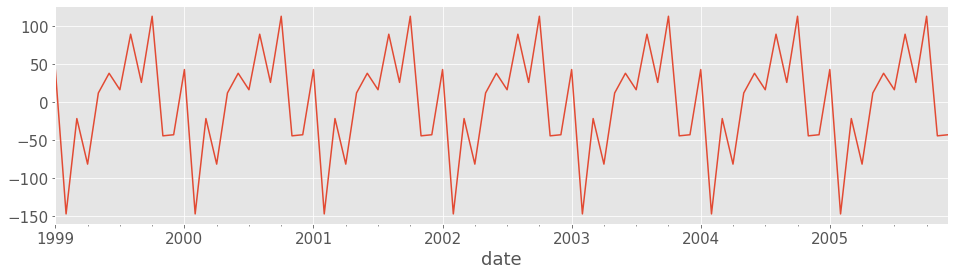

In [5]:
decomposition.seasonal["1999":"2005"].plot();

This plot shows that beef production really goes down at the beginning of each year, but it reaches its peak towards the end.

> Note on `seasonal_decompose` function: it produces small figures by default. You have to control its aspects on your own and the `plot` function does not accept most of the regular Matplotlib parameters.

Now, let's plot the seasonality of all types of meat over a 5-year interval:

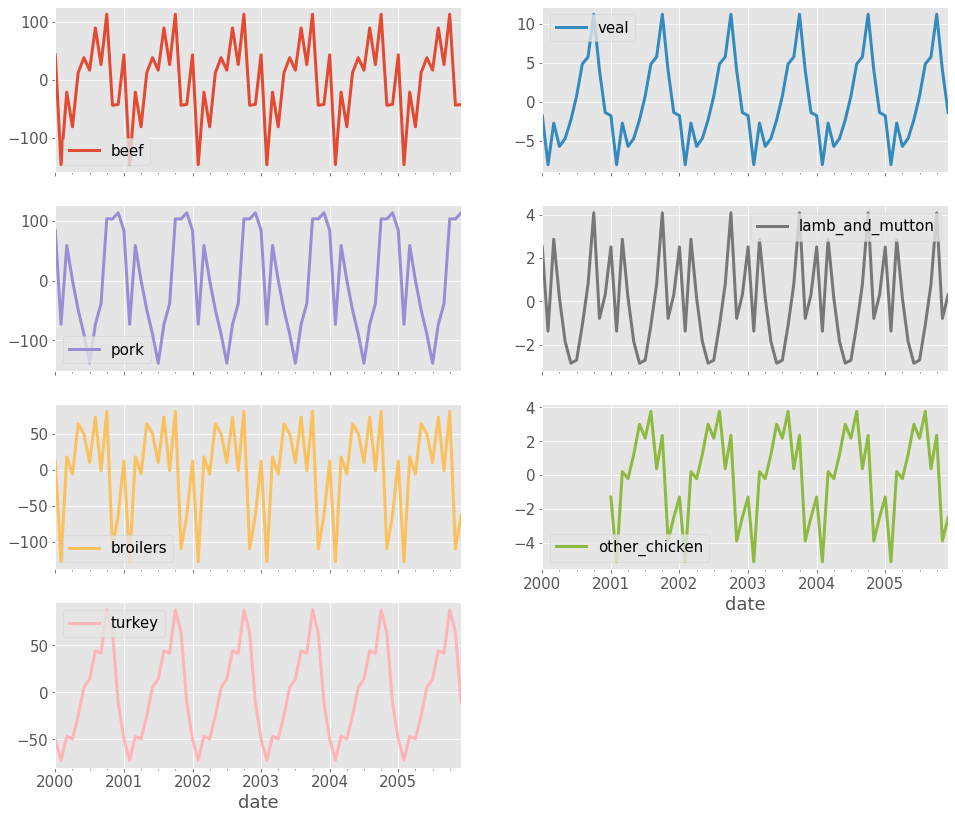

In [6]:
# Init empty dict to store decompose results
seasonality_dict = {}

for ts in meat.columns:
    decompositions = sm.tsa.seasonal_decompose(meat[ts].dropna())
    # Store the results back
    seasonality_dict[ts] = decompositions.seasonal

# Plot
rcParams["figure.figsize"] = 16, 14
pd.DataFrame(seasonality_dict)["2000":"2005"].plot(
    subplots=True, layout=(4, 2), linewidth=3
);

As you can see, each meat types have rather different seasonality patterns. Now, let's explore trends.

### 1.2 Trend Analysis

Once again, the overall trend of a time series shows whether it increased, decreased, or stayed constant (flat) over a time period. The above `DecomposeResult` object contains values that show the overall slope of a time series under the `trend` attribute.

Let's plot them for the meat production dataset:

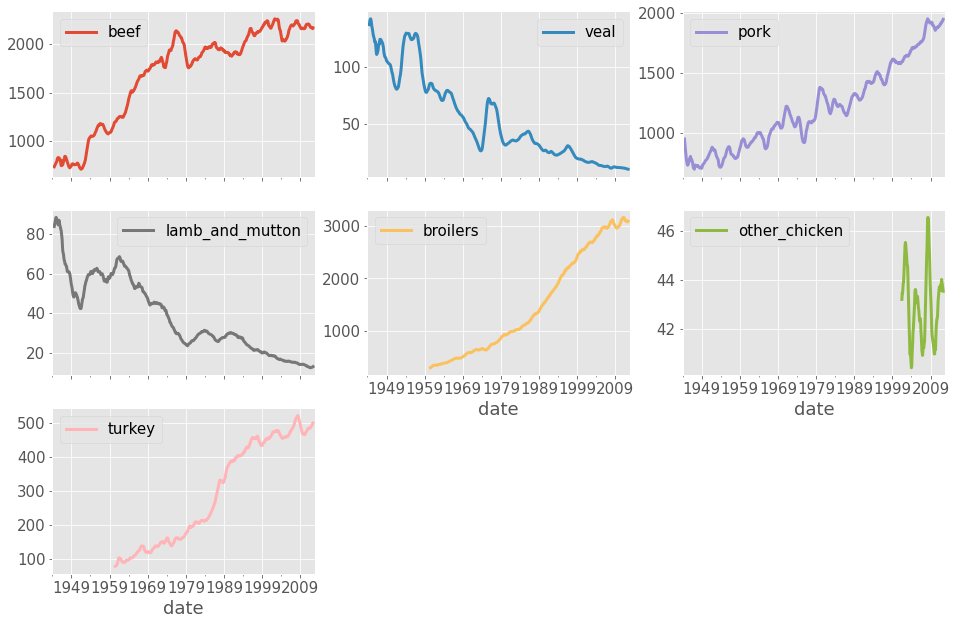

In [7]:
trend_dict = {}

for ts in meat.columns:
    decomposition = sm.tsa.seasonal_decompose(meat[ts].dropna())
    # Store back the results
    trend_dict[ts] = decomposition.trend

pd.DataFrame(trend_dict).plot(subplots=True, layout=(4, 3), linewidth=3);

This plot is massively insightful compared to the simple line plot we saw in the beginning. Indeed, we now see that meat from lambs and veal production has decreased dramatically since the 1940s.

This might be in part caused by the double or triple production increases in beef, broilers, and turkey. We are performing informed guesses now, but we will explore some powerful methods to validate them in later sections.

### 1.3 Noise

The third component of time series is noise. There is nothing fancy about it like the other two components. It only shows random and irregular data points that could not be attributed to either seasonality or noise.

You can plot them using the `resid` attribute from the `DecomposeResult` object:

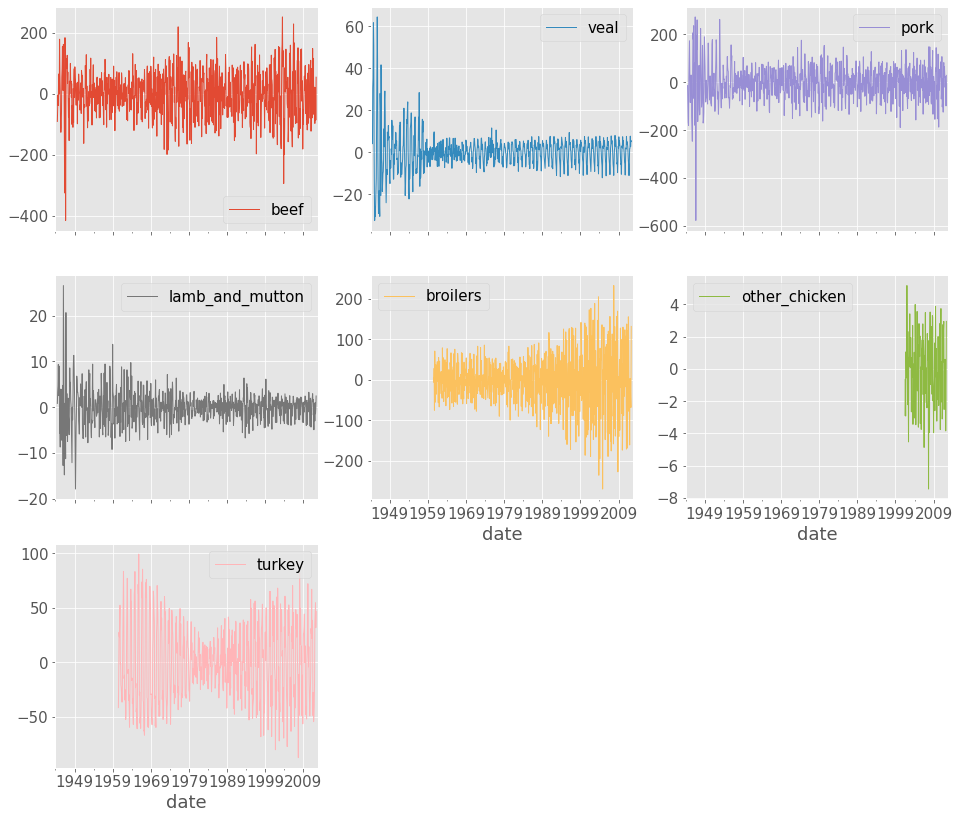

In [8]:
resid_dict = {}

for ts in meat.columns:
    decomposition = sm.tsa.seasonal_decompose(meat[ts].dropna())
    resid_dict[ts] = decomposition.resid

pd.DataFrame(resid_dict).plot(subplots=True, layout=(3, 3), linewidth=1);

> Calling `plot` on the whole `DecomposeResult` object will produce a plot with all components displayed on the same axes.

Decomposing your times series helps you think of them in a structured manner. Instead of imagining a series as a value changing over time, you can think of it as a distribution with a particular seasonality signal or a feature with a particular slope. This level of data understanding can be a key factor during feature engineering and modeling.

## 2. Working With Multiple Time Series

### 2.1 Generals

Working with multiple time series presents certain challenges. One example, as we saw, is the different scales each distribution comes in:

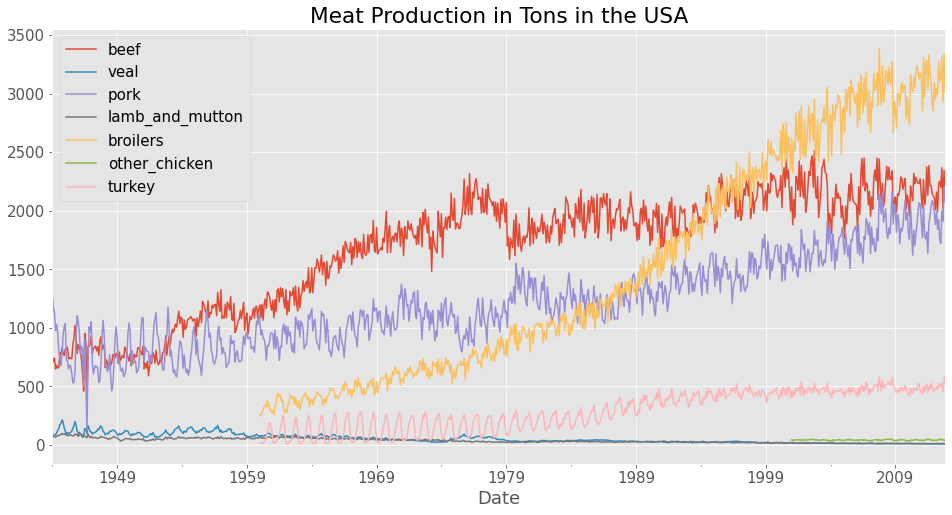

In [9]:
meat.plot(figsize=(16, 8), title="Meat Production in Tons in the USA")
plt.xlabel("Date");

When features with larger scales squish others to a flat line (lamb and veal), it is impossible to compare their growth. One solution is using normalization.

When normalizing time series, you divide every data point in the distribution by the first sample. This has the effect of representing every single data point as the percentage increase relative to the first sample:

In [10]:
meat.div(meat.iloc[0]).head()

,beef,veal,pork,lamb_and_mutton,broilers,other_chicken,turkey
date,,,,,,,
1944-01-01,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
1944-02-01,0.949401,0.905882,0.913281,0.808989,NaN,NaN,NaN
1944-03-01,0.986684,1.058824,0.881250,0.842697,NaN,NaN,NaN
1944-04-01,0.865513,1.047059,0.764062,0.741573,NaN,NaN,NaN
1944-05-01,0.906791,1.247059,0.803906,0.876404,NaN,NaN,NaN


The best part is now, each distribution has the same scale. Let's plot the meat production data by performing normalization:

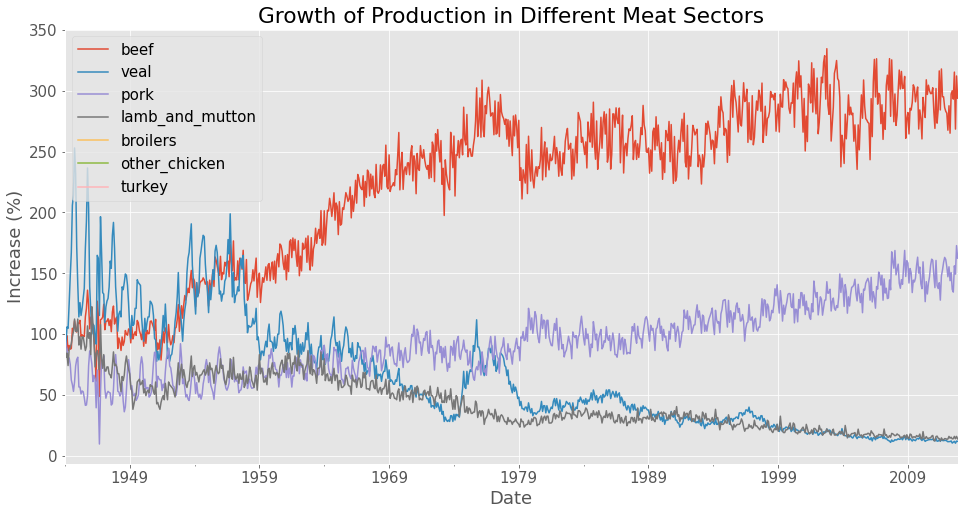

In [11]:
normalized = meat.div(meat.iloc[0]).mul(100)  # Multiply by 100 to get percentages

normalized.plot(figsize=(16, 8), title="Growth of Production in Different Meat Sectors")
plt.xlabel("Date")
plt.ylabel("Increase (%)");

Beef and pork saw the highest percentage increases while veal and lamb meat production plummeted over the given time period.

### 2.1 Relationships between time series with correlation

I know what you are saying: "Correlation? Really? What's new…."

But bear with me. A simple correlation heatmap can indeed tell a lot about the linear relationships between variables:

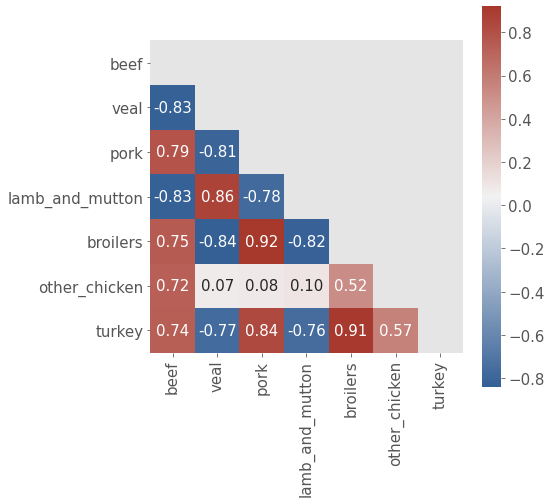

In [12]:
# Create a custom palette
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# Compute corr matrix
matrix = meat.corr(method="pearson")
# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matrix, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show();

What we are more interested in is how underlying components of time series affect each other. For example, let's see how the seasonality of each time series influences others:

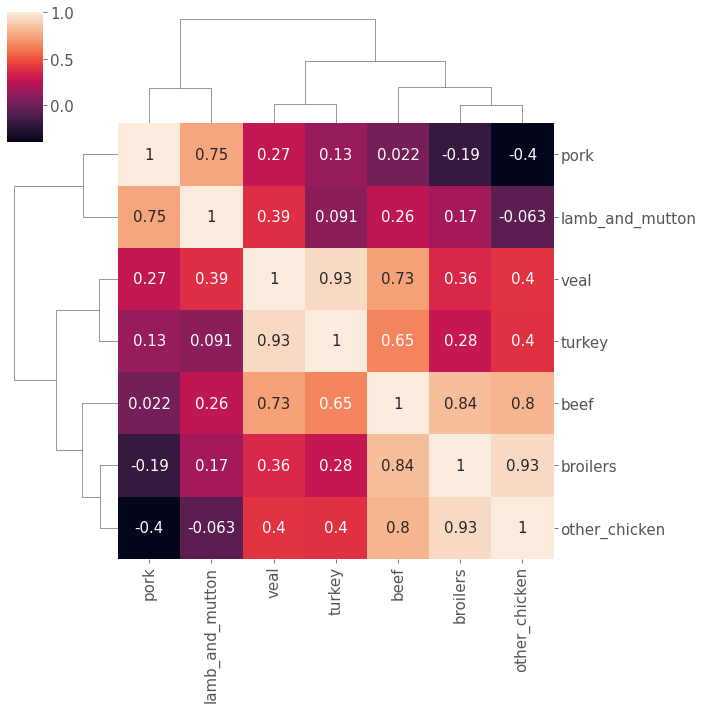

In [13]:
seasonality_dict = {
    ts: sm.tsa.seasonal_decompose(meat[ts].dropna()).seasonal for ts in meat.columns
}

# Compute corr matrix
seasonality_corr = pd.DataFrame(seasonality_dict).corr()

sns.clustermap(seasonality_corr, annot=True, square=True)
plt.show();

This time, we are using a ClusterMap rather than a heatmap to see closely correlated groups with the help of dendrograms immediately.

The plot tells us that the seasonality of beef, broilers, and other chicken meats are heavily correlated. The same is true with pork and lamb/mutton meats. This positive correlation can be indicative of close seasonality matches. 

For example, it is possible that increase/decrease patterns of beef, broilers, and other chicken meats often matched over the given period.

Let's do the same for trends, which I think should be more interesting:

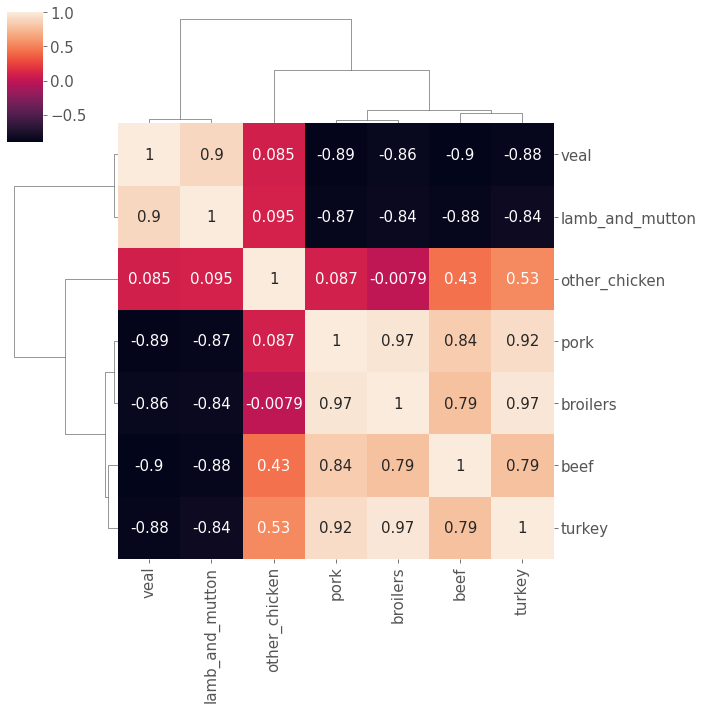

In [14]:
trend_dict = {
    ts: sm.tsa.seasonal_decompose(meat[ts].dropna()).trend for ts in meat.columns
}

# Compute corr matrix
trend_dict = pd.DataFrame(trend_dict).corr()

sns.clustermap(trend_dict, annot=True, square=True)
plt.show();

The above plot is awesome because it helps us validate our assumptions in the trend analysis section. Let's look at the normalized plot of meat production once again:

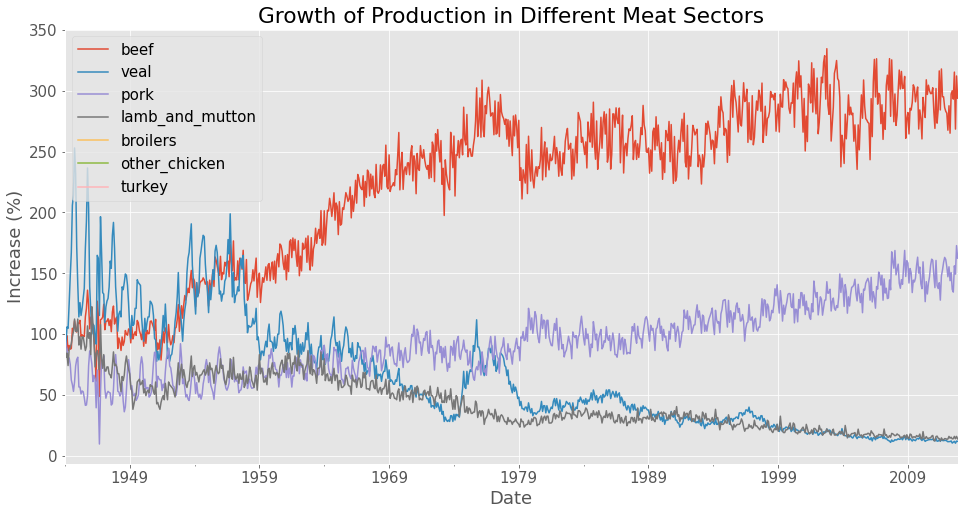

In [15]:
normalized = meat.div(meat.iloc[0]).mul(100)

normalized.plot(figsize=(16, 8), title="Growth of Production in Different Meat Sectors")
plt.xlabel("Date")
plt.ylabel("Increase (%)");

Can you match the patterns in the cluster map to the line plot? For example, beef has strong negative correlations with lamb/mutton and veal. This is matched by the fact that beef production tripled in amount while the production of the other two decreased by ~75% (seen from the line plot).

The same observations can be made between pork and veal, lamb/mutton.

### 2.2 Correlation does not mean causation

I want you to tread carefully when making assumptions about correlated features. Always remember that correlation does not mean causation. When two features are heavily correlated, it does not mean an increase in one causes an increase in another.

An example I like to use is that even though the number of storks in a town can correlate with the number of newborn babies, it does not mean that storks deliver the babies.

It might take a while to draw the line between correlation and causation clearly, so why don't you take a look at my [other article](https://towardsdev.com/how-to-not-misunderstand-correlation-75ce9b0289e?source=your_stories_page-------------------------------------) on the topic.

## 3. Autocorrelation and partial autocorrelation

### 3.1 Autocorrelation

Autocorrelation is a powerful analysis tool for modeling time series data. As the name suggests, it involves computing the correlation coefficient. But here, rather than computing it between two features, correlation of a time series is found with a lagging version of itself.

Let's first look at an example plot and explain further:

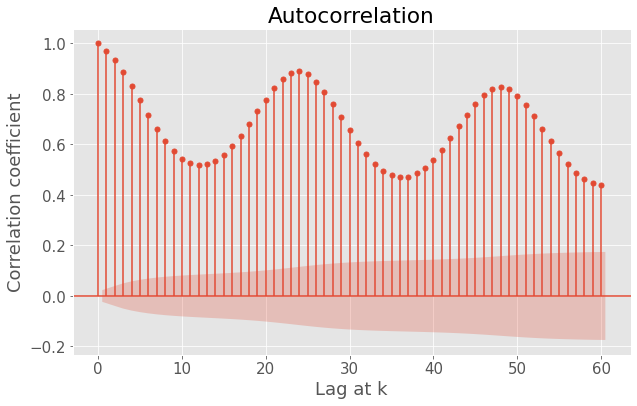

In [16]:
from statsmodels.graphics import tsaplots

rcParams["figure.figsize"] = 10, 6

# Stands for Time Series Analysis Plots (TSA Plots)
fig = tsaplots.plot_acf(tps["deg_C"], lags=60)

plt.xlabel("Lag at k")
plt.ylabel("Correlation coefficient")
plt.show()

The XAxis of an autocorrelation function plot (ACF) is the lag number k. For example, when k=1, the correlation is found by shifting the series by 1. This is the same as using the `shift` function of Pandas:

In [17]:
beef = meat["beef"].to_frame(name="beef")

beef["lag_1"] = beef["beef"].shift(periods=1)
beef["lag_2"] = beef["beef"].shift(periods=2)
beef["lag_3"] = beef["beef"].shift(periods=3)

beef.head()

,beef,lag_1,lag_2,lag_3
date,,,,
1944-01-01,751.0,NaN,NaN,NaN
1944-02-01,713.0,751.0,NaN,NaN
1944-03-01,741.0,713.0,751.0,NaN
1944-04-01,650.0,741.0,713.0,751.0
1944-05-01,681.0,650.0,741.0,713.0


The YAXis is the amount of correlation at each lag k. The shaded red region is a confidence interval - if the height of the bars is outside this region, it means the correlation is *statistically significant*.

Please pause and think of what you can learn from an ACF plot.

They offer an alternative way of detecting patterns and seasonality. For example, the ACF plot of temperature in Celcius shows that the correlation at every 15 lags decreases or every 25 lags increases.

When a clear trend exists in a time series, the autocorrelation tends to be high at small lags like 1 or 2. When seasonality exists, the autocorrelation goes up periodically at larger lags.

Let's look at another example:

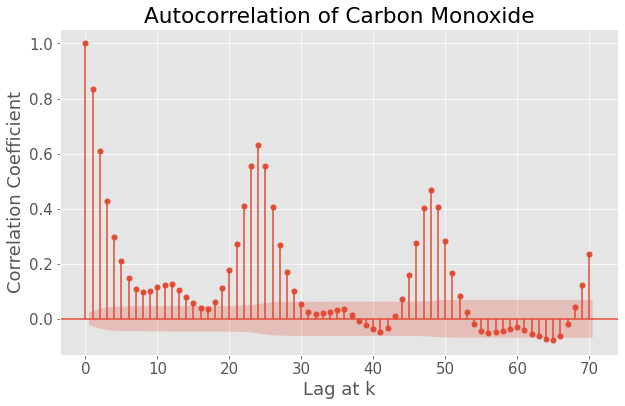

In [18]:
fig = tsaplots.plot_acf(tps["target_carbon_monoxide"], lags=70)

plt.title("Autocorrelation of Carbon Monoxide")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

The ACF of carbon monoxide confirms that small lags tend to have high correlations. It also shows that every 25 lags, the correlation increases significantly but quickly drops down to the negative. But most of the downward bars are inside the shaded area, suggesting that they are *not statistically significant*.

This ability to compare the relationship between past and present data points present a unique advantage. If you can associate the present value to points k periods before, this also means you can find a link to values that come after k periods.

Besides, understanding autocorrelation is key to modeling time series with ARIMA models (a topic for another article).

### 3.2 Partial autocorrelation

Even though discussing partial autocorrelation means we are getting way ahead of things, I will give you the gist.

It is similar to autocorrelation - it is calculated using the series and its lagged version at k:

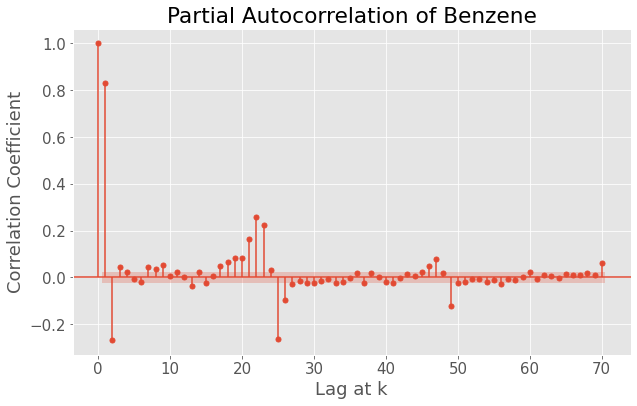

In [19]:
# Mind the extra 'p' in plot_pacf
fig = tsaplots.plot_pacf(tps["target_benzene"], lags=70)

plt.title("Partial Autocorrelation of Benzene")
plt.xlabel("Lag at k")
plt.ylabel("Correlation Coefficient")
plt.show();

The only difference is that this method tries to account for the effect the intervening lags have. For example, at lag 3, partial autocorrelation removes the effect lags 1 and 2 have on computing the correlation.

While autocorrelation is useful for analyzing a time series's properties and choosing what type of ARIMA model to use, partial autocorrelation tells what order of autoregressive model to fit.

Again, this topic will be discussed in-depth when we talk about forecasting. So, [stay tuned](https://medium.com/r/?url=https%3A%2F%2Fibexorigin.medium.com%2F)!

## Summary

Congratulations!

By reading this post, you learned powerful techniques to dissect any time series and derive meaningful insights. Most importantly, you now have the ability to apply these techniques to multiple time series and critically evaluate the relationships between them.

Thank you for reading, and I will see you in the next one!

### You might also be interested...
- [Every Pandas Function You Can (Should) Use to Manipulate Time Series](https://towardsdatascience.com/every-pandas-function-you-can-should-use-to-manipulate-time-series-711cb0c5c749?source=your_stories_page-------------------------------------)
- [Comprehensive Guide on Multiclass Classification Metrics](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd?source=your_stories_page-------------------------------------)
- [Practical Sklearn Feature Selection in 3 stages](https://towardsdatascience.com/4-part-practical-study-guide-to-sklearn-feature-selection-b959a28d9ef7?source=your_stories_page-------------------------------------)